# OCT data processing Thorlabs Ganymede software

This is a demo to load and process 1D or 2D OCT data from raw Thorlabs OCT data. Dechirp

In [2]:
# load the relevant modulus
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Functions for reading OCT data
import ReadOCTfile
dir(ReadOCTfile)

# Functions for processing OCT data
import DataProcessingOCT
dir(DataProcessingOCT)

 # load dechirp to be used in the calculations
dechirp=np.fromfile('datademo/Chirp.data',np.float32)

Loading the data

In [3]:
t0=time()

file_name="datademo/Default_0001_Mode2D.oct"

# load the data from the file specified above
header,rawdata,spectrum,FOV=ReadOCTfile.OCTgetDataCombined(file_name,spectrumindex=0)   
Ascanav=int(header.Ocity.Acquisition.IntensityAveraging.AScans.string)

# process the data into a Bscan image
image=DataProcessingOCT.calc_Bscan(rawdata,spectrum,dechirp,Ascanav,apodization='hanning',filters='none',objective='LK4')

t1=time()
print('It took ',t1-t0,' s to load and process file ',file_name)

It took  2.899402141571045  s to load and process file  datademo/Default_0001_Mode2D.oct


(Text(0.5, 0, 'OPL-coordinate (pixels)'), Text(0, 0.5, 'OCT intensity (dB)'))

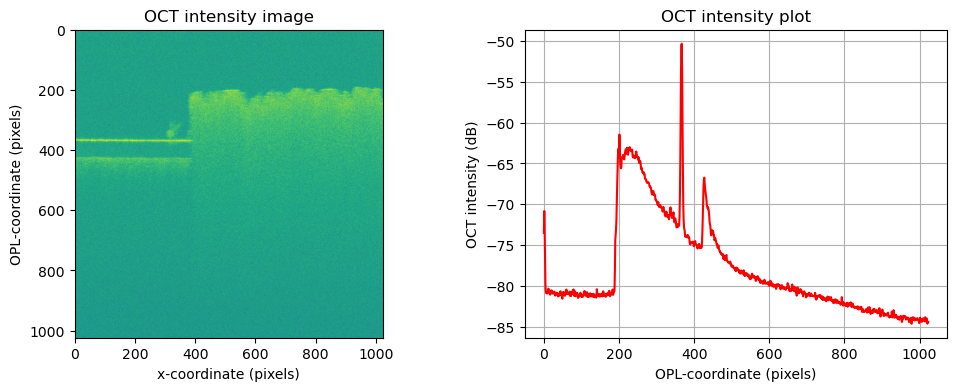

In [5]:
OCTintensity=np.abs(image)**2
dB_im=10*np.log10(OCTintensity)

N_z = OCTintensity.shape[0] # Number of pixels in depth
N_t = OCTintensity.shape[1] # Number of pixels in time

# Plot the figures
plt.figure(1, figsize=[12,4])
plt.subplot(121)
plt.imshow(dB_im), plt.title('OCT intensity image')
plt.xlabel('x-coordinate (pixels)'), plt.ylabel('OPL-coordinate (pixels)')

plt.subplot(122)
plt.title('Mean OCT intensity'), plt.title('OCT intensity plot')
plt.plot(10*np.log10(np.mean(OCTintensity, axis=1)), '-r'), plt.grid()
plt.xlabel('OPL-coordinate (pixels)'), plt.ylabel('OCT intensity (dB)')